In [62]:
import glob
import bs4 as bs
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datasets_info = {}
with open('../../Resources/data/datasets.csv') as ds_csv:
    ds_reader = csv.DictReader(ds_csv)
    for ds in ds_reader:
        datasets_info[ds["name"]] = {
                                        "doi":ds["doi"],
                                        "title":ds["paper_title"],
                                        "name":ds["name"],
                                        "aliases":ds["aliases"].split(","),
                                        "url":ds["url"]
                                     }
datasets_info

{'ACDC': {'doi': '10.1109/TMI.2018.2837502',
  'title': 'Deep Learning Techniques for Automatic MRI Cardiac Multi-Structures Segmentation and Diagnosis: Is the Problem Solved?',
  'name': 'ACDC',
  'aliases': ['ACDC', 'Automated Cardiac Diagnosis Challenge', 'AC17'],
  'url': 'None'},
 'Sunnybrook': {'doi': 'https://doi.org/10.54294/g80ruo',
  'title': 'Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI.',
  'name': 'Sunnybrook',
  'aliases': ['Sunnybrook'],
  'url': 'None'},
 'STACOM’11': {'doi': '10.1007/978-3-642-28326-0_9',
  'title': 'Left Ventricular Segmentation Challenge from Cardiac MRI: A Collation Study',
  'name': 'STACOM’11',
  'aliases': ['STACOM’11', "STACOM'11"],
  'url': 'None'},
 'RVSC': {'doi': 'https://doi.org/10.1016/j.media.2014.10.004',
  'title': 'Right ventricle segmentation from cardiac MRI: A collation study',
  'name': 'RVSC',
  'aliases': ['RVSC'],
  'url': 'None'},
 'M&Ms': {'doi': '10.1109/tmi.2021.3090082',
  'title': 'Multi-Centre, Mu

In [74]:
datasets_columns = ["ACDC","BRATS","LIDC-IDRI","DRIVE","PROMISE12","Chexpert","PadChest","PAD-UFES-20","CAMELYON","CADDementia","MRNet","PROSTATEx","MIMIC","CBIS-DDSM"]

In [146]:
xml_paths = glob.glob("../../Results/extraction/grobid_extraction/*")
res = []
stop = False
for i,path in enumerate(xml_paths):
    paper_name = path.removeprefix("../../Results/extraction/grobid_extraction/").removesuffix(".grobid.tei.xml").removesuffix(".txt")
    paper_res = {ds:[] for ds in datasets_info}
    paper_res["title"] = paper_name
    if path.endswith(".xml"):
        with open(path) as fp:
            soup = bs.BeautifulSoup(fp,features="xml")
        for ds in datasets_info:
            ds_name_aliases = [f"({a})" for a in datasets_info[ds]["aliases"]]
            ds_name_aliases_regex = "|".join(ds_name_aliases)
            for elem in soup.findAll(string=re.compile(f"(?<![^_\\W]){ds_name_aliases_regex}(?![^_\\s\\d\\.\\),'])")):
                #To detect in "normal" text
                parent_div = elem.find_parent("div")
                if parent_div:
                    if parent_div.find_parent("abstract"):
                        paper_res[ds].append("Abstract")
                    elif parent_div.find("head"):
                        head_text = parent_div.find("head").text.lower()
                        if "dataset" in head_text or "method" in head_text or "results" in head_text or "setup" in head_text:
                            to_append = "Experiment and Results"
                        else:
                            to_append = "Other"
                        paper_res[ds].append(to_append)
                
                #To detect in figures or tables
                parent_figure = elem.find_parent("figure")
                if parent_figure:
                    if not paper_res[ds]:
                        paper_res[ds] = []
                    if parent_figure.get("type") == "table":
                        paper_res[ds].append("Table")
                    else:
                        paper_res[ds].append("Figure")

    res.append(paper_res)

In [150]:
ds = "ACDC"
ds_name_aliases = [f"({a})" for a in datasets_info[ds]["aliases"]]
ds_name_aliases.append(f"({ds})")
ds_name_aliases_regex = "|".join(ds_name_aliases)
print(f"(?<![^_\\W]){ds_name_aliases_regex}(?![^_\\s\\d\\.\\),'])")

(?<![^_\W])(BRATS)|(BraTs)|(BraTS)|(BRATS)(?![^_\s\d\.\),'])


In [ ]:
df = pd.DataFrame.from_records(res)
l = df["ACDC"]
result = []
for nestedlist in l:
    result.extend(nestedlist)
section_count = np.unique(result,return_counts=True)
print(section_count[0])
print(section_count[1])

In [148]:
df = pd.DataFrame.from_records(res)
cumul_count = []
lst_field = ["Abstract","Table","Figure","Experiment and Results","Other"]
for d in datasets_columns:
    l = df[d]
    result = []
    for nestedlist in l:
        result.extend(nestedlist)
    
    if result:
        section_count = np.unique(result,return_counts=True)
        tmp = {section_count[0][i]:section_count[1][i] for i in range(len(section_count[0]))}
        dataset_section_count = {f:tmp.get(f,0) for f in lst_field}
        dataset_section_count["dataset"] = d
        cumul_count.append(dataset_section_count)

,Abstract,Table,Figure,Experiment and Results,Other
dataset,,,,,
ACDC,9,72,30,92,69
BRATS,34,83,45,100,205
LIDC-IDRI,8,4,1,15,25
DRIVE,9,32,19,42,63
PROMISE12,1,8,1,7,15
Chexpert,0,6,1,4,8
PadChest,1,3,0,2,8
CAMELYON,0,6,0,8,6
MRNet,1,6,1,2,11


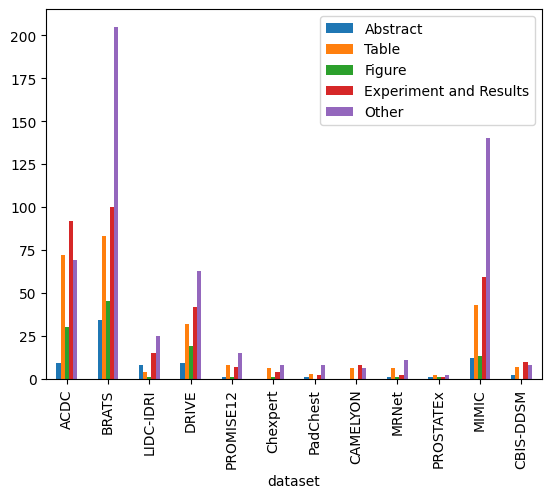

In [149]:
df_dataset = pd.DataFrame.from_records(cumul_count)
df_dataset = df_dataset.set_index("dataset")
df_dataset.plot.bar()
df_dataset